In [22]:
# Libraries
import torch
import torchvision                                                       
import torchvision.transforms as transforms
import os.path

# Dataset
dataset_dir = os.path.join(os.path.expanduser("~"), 'Datasets', 'FashionMNIST')

# Load the dataset training data
train_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                           train=True,
                                           transform= None, #transforms.ToTensor(),
                                           download=True)

# Load the dataset test data
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                                 transform= None, #transforms.ToTensor(),
                                                 train=False)

In [23]:
class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)

train_dataset = DatasetTransformer(train_dataset, transforms.ToTensor())
test_dataset  = DatasetTransformer(test_dataset , transforms.ToTensor())

In [24]:
# Dataloaders
# Loading the dataset is using 4 CPU threads
num_threads = 4    

# Using minibatches of 128 samples 
batch_size  = 64   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                # <-- this reshuffles the data at every epoch
                                          num_workers=num_threads)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)

print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 60000 images, in 938 batches
The test set contains 10000 images, in 157 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


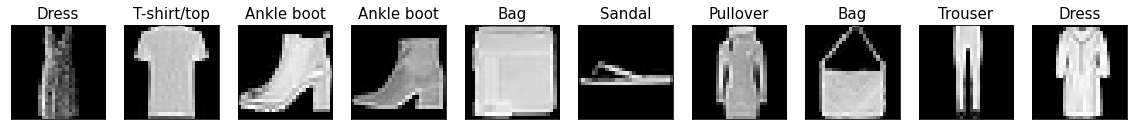

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nsamples=10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs, labels = next(iter(train_loader))
# print(imgs.shape, labels.shape)
imgs = imgs.numpy()
fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('fashionMNIST_samples.png', bbox_inches='tight')
plt.show()

In [30]:
import torch.nn as nn
import torch.optim as optim

def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.ReLU(inplace=True)]

class Model(nn.Module):
    def __init__(self, input_size, num_classes, l2_reg):
        super(Model, self).__init__()
        self.l2_reg = l2_reg
        self.lin1 = nn.Linear(input_size, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, num_classes)


    def penalty(self):
        return self.l2_reg * (self.lin1.weight.norm(2) + self.lin2.weight.norm(2) + self.lin3.weight.norm(2))

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = nn.functional.relu(self.lin2(x))
        y = self.lin3(x)
        return y
        
model = Model(1*28*28, 10, 0.0001)

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


model.to(device)

Model(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
)

In [31]:
from torch.autograd import Variable
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
f_loss = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        # Transfering images and labels to GPU if available
        imgs, labels = imgs.to(device), labels.to(device)
        train = imgs
                
        # Forward pass 
        outputs = model(train)
        loss = f_loss(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()  
        count += 1
    
        # Testing the model
    
        if count % 50 == 0:
            total = 0
            correct = 0
        
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels_list.append(labels)
                test = imgs
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
          
    print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 938, Loss: 0.2280733585357666, Accuracy: 84.12000274658203%
Iteration: 1876, Loss: 0.17532502114772797, Accuracy: 86.11000061035156%
Iteration: 2814, Loss: 0.35688844323158264, Accuracy: 87.25%
Iteration: 3752, Loss: 0.1771361231803894, Accuracy: 86.93000030517578%
Iteration: 4690, Loss: 0.47459903359413147, Accuracy: 87.87999725341797%


In [32]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [33]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

# Confusion Matrix
confusion_matrix(labels_l, predictions_l)
print("Classification report:\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     93000
           1       0.98      0.96      0.97     93000
           2       0.76      0.74      0.75     93000
           3       0.85      0.88      0.86     93000
           4       0.73      0.79      0.75     93000
           5       0.96      0.94      0.95     93000
           6       0.66      0.60      0.63     93000
           7       0.92      0.94      0.93     93000
           8       0.96      0.96      0.96     93000
           9       0.94      0.95      0.94     93000

    accuracy                           0.86    930000
   macro avg       0.86      0.86      0.86    930000
weighted avg       0.86      0.86      0.86    930000




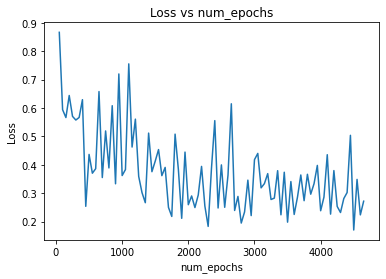

In [36]:
# Plotting
plt.plot(iteration_list, loss_list)
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Loss vs num_epochs")
plt.show()